<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/2_Seal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net seal detection

In [6]:
#Connect to the google drive if you use Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [7]:
!pip install torch torchvision segmentation-models-pytorch tifffile tabulate -q

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torchvision
from PIL import Image
import torch.nn.functional as F
import zipfile
import time
from tabulate import tabulate
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

### Define path to tensor files and load train and test data


In [ ]:
# Trying the network with the tree data set https://www.kaggle.com/datasets/earthshot/tree-binary-segmentation?resource=download
# DO NOT RUN WITH SEAL DATA
# DELETE THIS CODE BLOCK ONCE WE HAVE OUR ACTUAL IMAGES

# import torchvision.transforms.functional as TF
# import random

# Change to relative file paths
#train_data_path = "drive/MyDrive/SealNN/Data/Train"
#test_data_path = "drive/MyDrive/SealNN/Data/Test"
# train_data_path = "C:/SealNN/data_test/train"
# test_data_path = "C:/SealNN/data_test/test"


# batch_size = 8  # Can be changed later

# def trans(image, mask):
#     # Resize and grayscale both mask and image
#     resize = transforms.Resize(size=(320, 320))
#     grayscale = transforms.Grayscale(num_output_channels=1)

#     image = resize(image)
#     mask = resize(mask)

#     image = grayscale(image)
#     mask = grayscale(mask)

#     # Random horizontal flipping
#     if random.random() > 0.5:
#         image = TF.hflip(image)
#         mask = TF.hflip(mask)

#     # Random rotation
#     angle = random.uniform(0, 60)  # Random angle between 0 and 60 degrees
#     image = TF.rotate(image, angle)
#     mask = TF.rotate(mask, angle)

#     # Convert to tensor
#     image = TF.to_tensor(image)
#     mask = TF.to_tensor(mask)

#     return image, mask

# # Custom dataset to properly import for segmentation
# def segmentation_dataset(data_path, transform=None):
#     images_path = os.path.join(data_path, "Images")
#     masks_path = os.path.join(data_path, "Masks")
#     image_files = os.listdir(images_path)

#     dataset = []
#     for img_name in image_files:
#         # Read image and corresponding mask using torchvision.io.read_image
#         img_path = os.path.join(images_path, img_name)
#         mask_path = os.path.join(masks_path, img_name.replace(".jpg", ".png"))

#         image = Image.open(img_path)
#         mask = Image.open(mask_path)

#         if transform:
#             mask, image = trans(mask, image)
#             #mask = transform(mask)  # Apply transform to both image and corresponding mask

#         dataset.append((image, mask))  # Append the image-mask pair to the dataset

#     return dataset

# # Create train and test datasets without augmentation
# train_dataset = segmentation_dataset(train_data_path, transform=trans)
# test_dataset = segmentation_dataset(test_data_path, transform=trans)

# # Create train and test data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Shuffle on or off?


In [10]:
#Make sure to remove the existing data folder before running this unzip code
zip_path = '/content/drive/MyDrive/SealNN/data.zip'
data_path = "/content/drive/MyDrive/SealNN/"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)


In [11]:
# Choose RGB or BW
col = "panchromatic"
#col = "pansharpened"

train_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/train" #TODO: change to relative file path
val_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/val"
test_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/test"

#Custom dataset to properly import for segmentation
def segmentation_dataset(data_path, transform=None):
   images_path = os.path.join(data_path, "images")
   masks_path = os.path.join(data_path, "masks")
   image_files = os.listdir(images_path)

   dataset = []
   for img_name in image_files:
         image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
         mask = tifffile.imread(os.path.join(masks_path, img_name[:-4] + '.tif')) #read corresponding mask .tif file

         if transform:
           image = transform(image)
           mask = transform(mask) #apply transform to both image and corresponding mask

         dataset.append((image, mask)) #append the image-mask pair in the dataset

   return dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) #Add more transforms to include e.g. data augmentation



In [ ]:
# Create train and test datasets without augmentation
train_dataset = segmentation_dataset(train_data_path, transform=transform)
val_dataset = segmentation_dataset(val_data_path, transform=transform)
test_dataset = segmentation_dataset(test_data_path, transform=transform)

batch_size = 8 #Can be changed later

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Shuffle on or off?

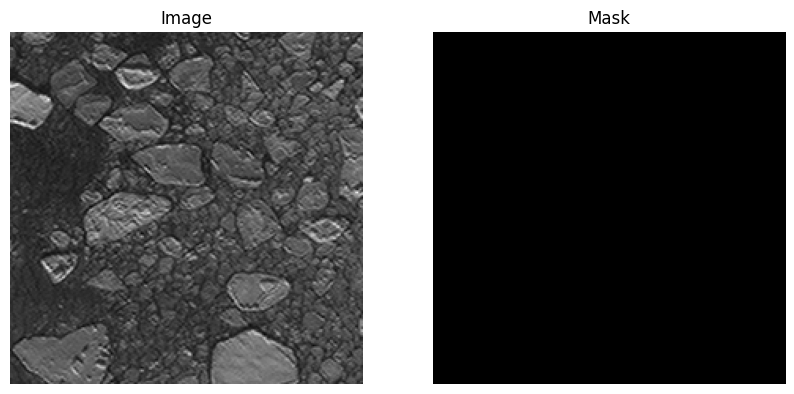

In [12]:
image, mask = train_dataset[13]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

### Define the model (U-Net)

In [ ]:
#source:https://smp.readthedocs.io/en/latest/models.html#unet
model = smp.Unet(
    encoder_name="resnext50_32x4d", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 we chose efficientnet-b1 based on the SealNet 2.0
    encoder_weights=None, # we do not have a pretrained model, so we put none and the model will use random weigths
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1 # model output channels (number of classes in your dataset)

)

### Training and testing

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Train Loss: 0.7843, Val Loss: 0.9802, Epoch time:  18.79s, LR: 0.003
Epoch 2/20, Train Loss: 0.5199, Val Loss: 0.6030, Epoch time:  18.95s, LR: 0.003
Epoch 3/20, Train Loss: 0.3958, Val Loss: 0.5700, Epoch time:  18.65s, LR: 0.003
Epoch 4/20, Train Loss: 0.3616, Val Loss: 0.4681, Epoch time:  18.42s, LR: 0.00030000000000000003
Epoch 5/20, Train Loss: 0.3199, Val Loss: 0.3096, Epoch time:  18.47s, LR: 0.00030000000000000003
Epoch 6/20, Train Loss: 0.2729, Val Loss: 0.3148, Epoch time:  18.64s, LR: 0.00030000000000000003
Epoch 7/20, Train Loss: 0.2482, Val Loss: 0.2900, Epoch time:  18.66s, LR: 0.00030000000000000003
Epoch 8/20, Train Loss: 0.2437, Val Loss: 0.3138, Epoch time:  18.57s, LR: 3.0000000000000004e-05
Epoch 9/20, Train Loss: 0.2345, Val Loss: 0.2514, Epoch time:  18.51s, LR: 3.0000000000000004e-05
Epoch 10/20, Train Loss: 0.2269, Val Loss: 0.2595, Epoch time:  18.52s, LR: 3.0000000000000004e-05
Epoch 11/20, Train Loss: 0.2291, Val Loss: 0.2552, Epoch time:  18.54s

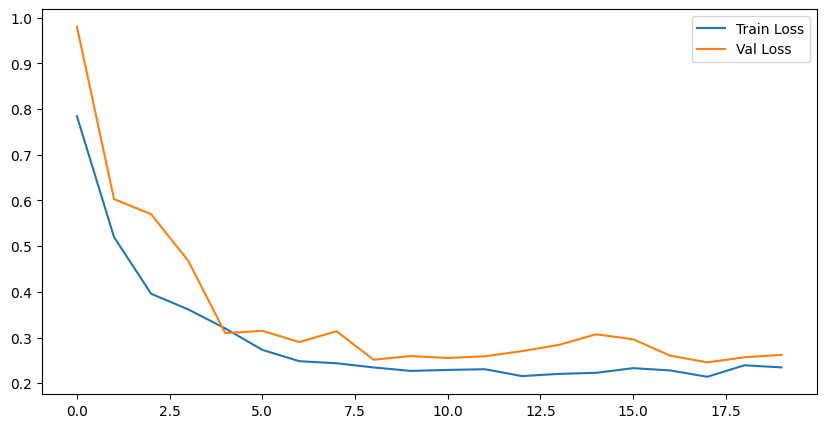

In [ ]:
learning_rate = 0.003
num_epochs = 20
# Define the loss function and optimizer
# Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
alpha = 0.1
beta = 0.9



#https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/metric.py
def metrics(groundtruths, predictions, threshold = 0.5):
        output = torch.cat(groundtruths, dim = 0)
        target = torch.cat(predictions, dim = 0)
        #pred = (all_outputs > threshold).float()

        #output = predictions.view(-1, )
        #target = groundtruths.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        eps = 1e-7 # Small number to avoid devision by zero

        pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
        precision = (tp + eps) / (tp + fp + eps)
        recall = (tp + eps) / (tp + fn + eps)
        specificity = (tn + eps) / (tn + fp + eps)

        table = [["Pixel Accuracy", pixel_acc],
                 ["Dice", dice],
                 ["Precision", precision],
                 ["Recall", recall],
                 ["Specificity", specificity]]

        head = ["Metric", "Value"]

        print(tabulate(table, headers=head, tablefmt="grid"))

        return pixel_acc, dice, precision, recall, specificity

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=alpha, beta=beta):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky



# What loss function do we want
criterion = TverskyLoss()
#criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss with logits

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

best_loss = 10000000
best_model = 0
best_epoch = 0

for epoch in range(num_epochs):
    start_time = time.time() #start time for epoch

    model.train()
    train_loss = 0.0
    tr_all_outputs = []
    tr_all_masks = []
    for image, mask in train_loader:
        image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, mask) #mask.float() maybe?
        loss.backward()
        optimizer.step()
        outputs = torch.sigmoid(outputs)
        outputs= outputs.cpu().detach()
        tr_all_outputs.append(outputs)
        tr_all_masks.append(mask.cpu().detach())
        train_loss += loss.item()


    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_all_outputs = []
    val_all_masks = []
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
            outputs = model(image)
            loss = criterion(outputs, mask) #mask.float() maybe?
            outputs = torch.sigmoid(outputs)
            outputs= outputs.cpu().detach()
            val_all_outputs.append(outputs)
            val_all_masks.append(mask.cpu().detach())
            val_loss += loss.item()


    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step()

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      best_epoch = epoch+1


    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch time: {epoch_time: .2f}s, LR: {get_lr(optimizer)}')
print(f"Best epoch is {best_epoch}, with a validation loss of {best_loss}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [ ]:
# Run this code if your model is good, you can save the weights to drive:
import os.path
from os import path

if path.exists("/content/drive/MyDrive/SealNN/models") == False:
  os.mkdir("/content/drive/MyDrive/SealNN/models")

model_name = "Model_20" # Make sure you change the name to the ID number we used in the excel!
model_path = "/content/drive/MyDrive/SealNN/models/"+ model_name
torch.save(best_model.state_dict(), model_path)

## Test accuracy and precision/recall curve

precision = how many of the ground truth instances are found?
recall = how many of the predicted instances are correct?

+----------------+----------+
| Metric         |    Value |
+================+==========+
| Pixel Accuracy | 0.998812 |
+----------------+----------+
| Dice           | 0.622063 |
+----------------+----------+
| Precision      | 0.486656 |
+----------------+----------+
| Recall         | 0.861869 |
+----------------+----------+
| Specificity    | 0.998968 |
+----------------+----------+


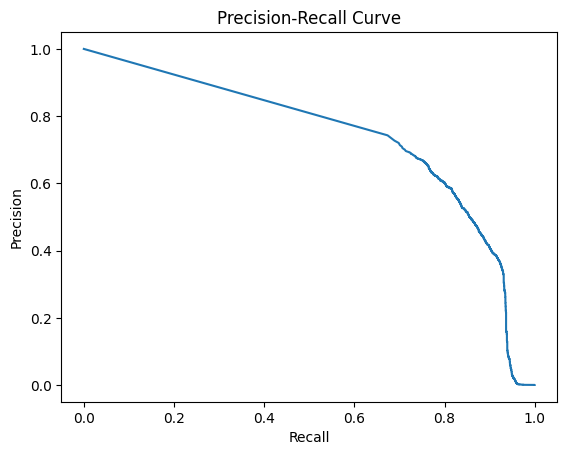

In [ ]:
# Evaluate the model and collect outputs and masks
best_model.eval()

te_all_outputs = []
te_all_masks = []

for image, mask in test_loader:
    image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
    outputs = best_model(image)

    outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
    outputs = outputs.cpu().detach()

    te_all_outputs.append(outputs)
    te_all_masks.append(mask.cpu().detach())


metrics(te_all_outputs, te_all_masks)

te_all_outputs = torch.cat(te_all_outputs).view(-1)
te_all_masks = torch.cat(te_all_masks).view(-1)


te_all_outputs_np = te_all_outputs.numpy()
te_all_masks_np = te_all_masks.numpy()

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(te_all_masks_np, te_all_outputs_np)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, marker=' ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# Prediction visualisation


Prediction shape: torch.Size([1, 1, 224, 224])
Image shape for imshow: (224, 224)
True mask shape for imshow: (224, 224)
Predicted mask shape for imshow: (224, 224)


(-0.5, 223.5, 223.5, -0.5)

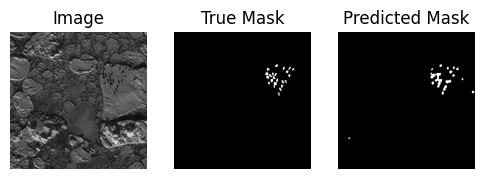

In [ ]:
# Index of the image you want to visualize
i = 41

image, mask = test_dataset[i]
image = image.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension
mask = mask.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension

best_model.eval()
with torch.no_grad():
  pred = model(image)
print(f'Prediction shape: {pred.shape}')

pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # Convert prediction to numpy array
pred_print = (pred == 1).astype(float)

fig, axes = plt.subplots(1, 3, figsize=(6, 2))
image_np = image.squeeze().cpu().numpy()  # Keep the shape as (1, 224, 224) if it's a single channel
if image_np.ndim == 3:
   image_np = image_np.transpose(1, 2, 0)  # Convert from tensor format (C, H, W) to (H, W, C)
print(f'Image shape for imshow: {image_np.shape}')
axes[0].imshow(image_np.squeeze(), cmap='gray')  # Use grayscale if single channel
axes[0].set_title('Image')
axes[0].axis('off')

mask_np = mask.squeeze().cpu().numpy()
print(f'True mask shape for imshow: {mask_np.shape}')
axes[1].imshow(mask_np, cmap='gray')  # Convert mask to numpy array
axes[1].set_title('True Mask')
axes[1].axis('off')

print(f'Predicted mask shape for imshow: {pred_print.shape}')
axes[2].imshow(pred_print, cmap='gray')  # Use grayscale colormap for binary mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

In [ ]:
print(len(test_dataset))

45


<ipython-input-74-df2d7cd6d9d4>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(6, 2))


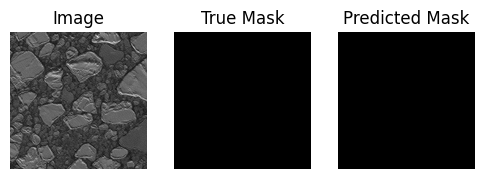

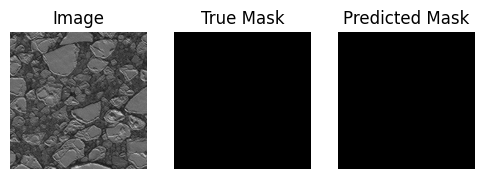

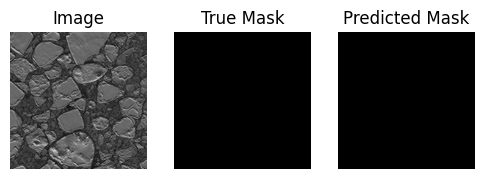

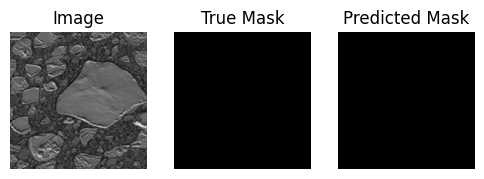

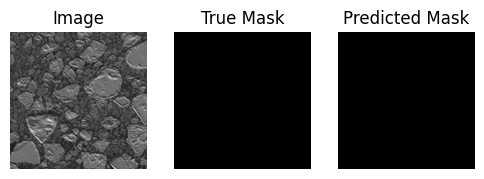

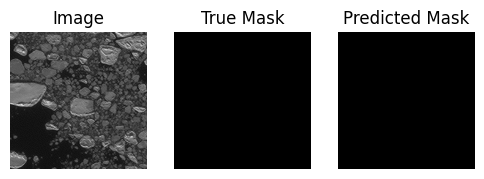

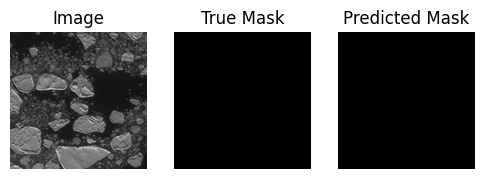

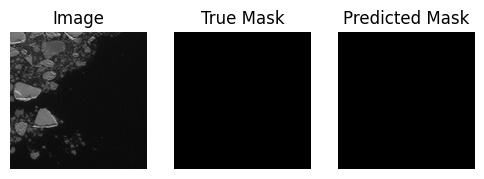

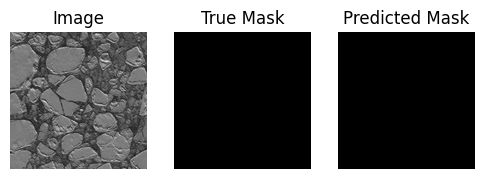

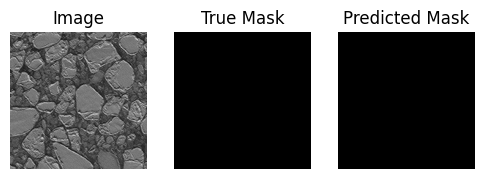

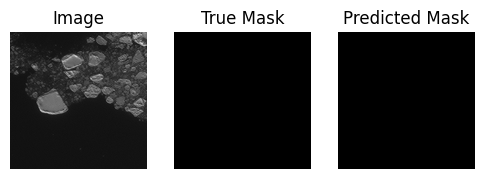

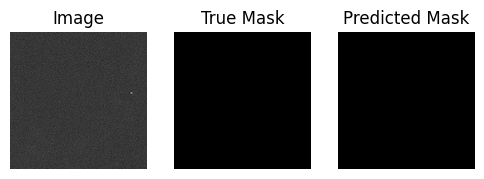

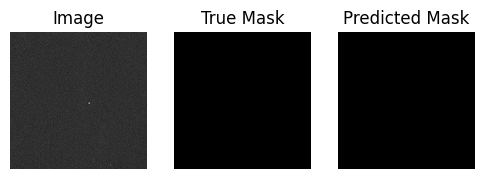

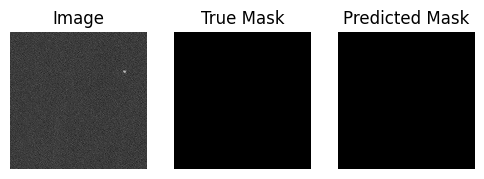

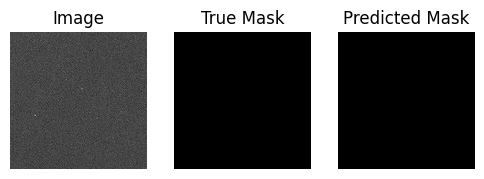

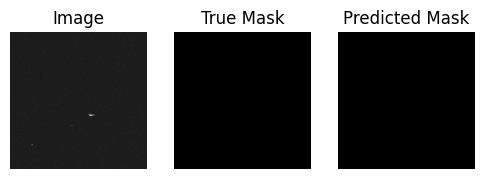

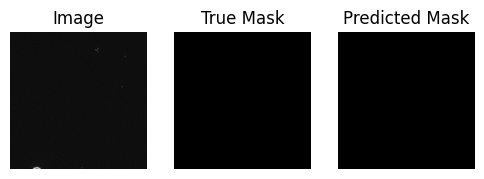

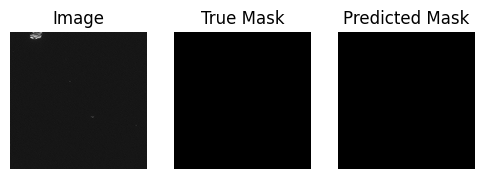

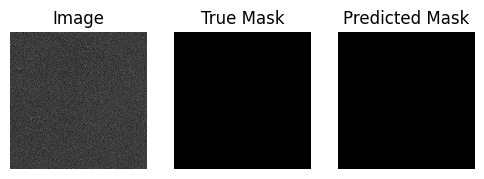

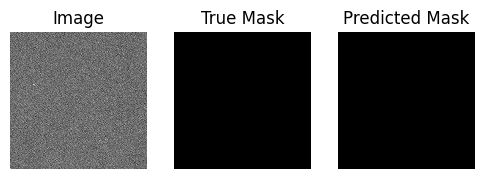

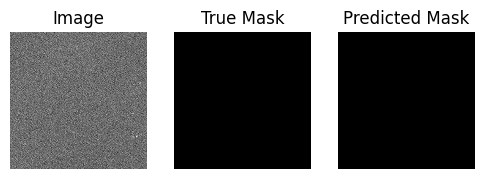

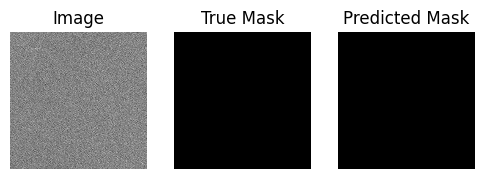

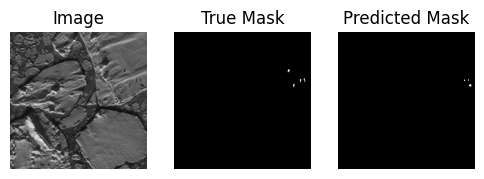

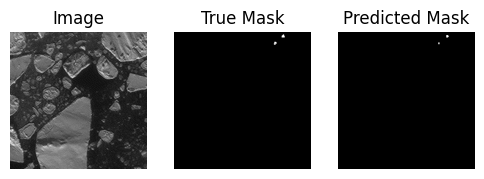

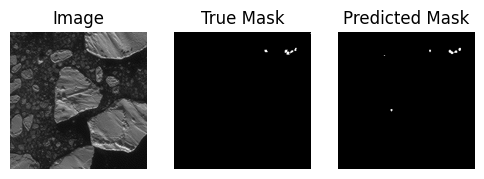

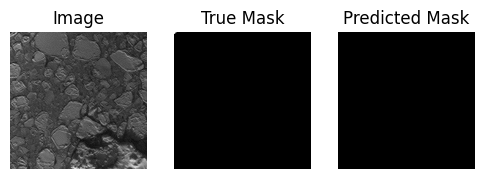

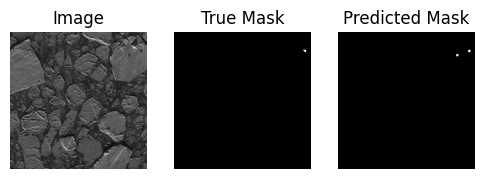

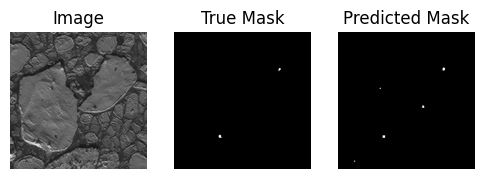

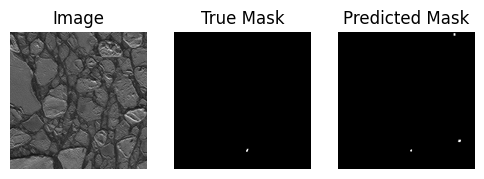

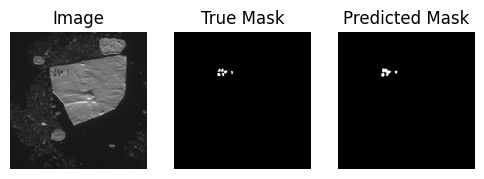

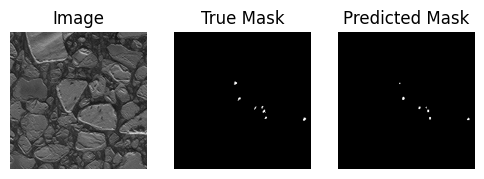

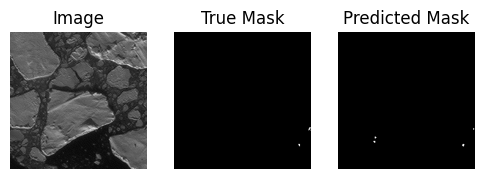

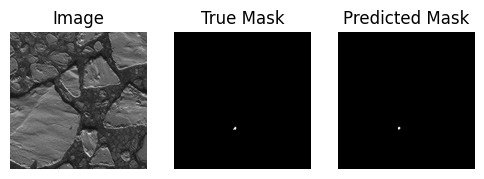

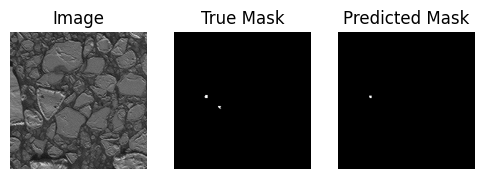

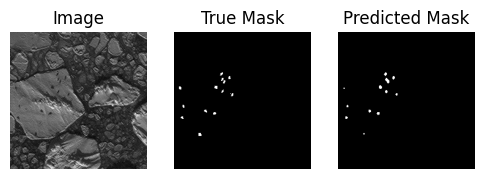

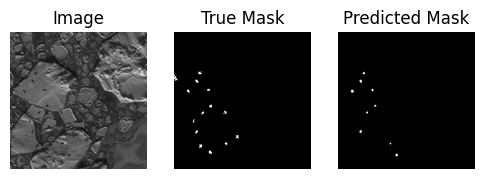

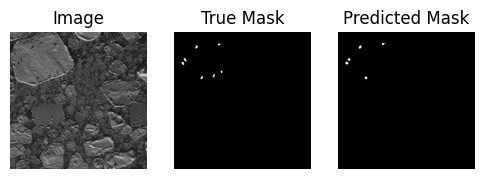

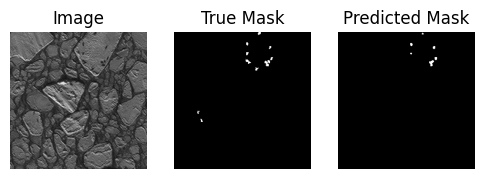

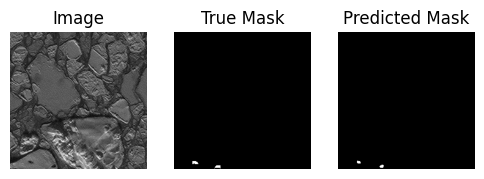

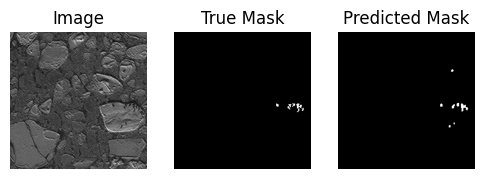

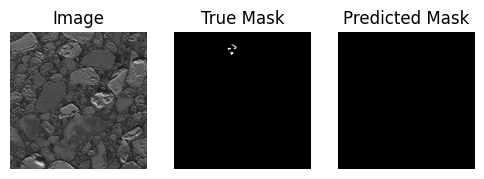

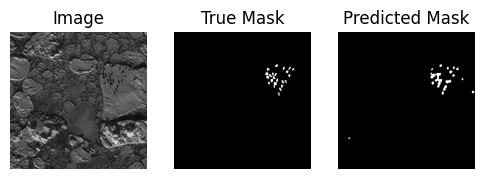

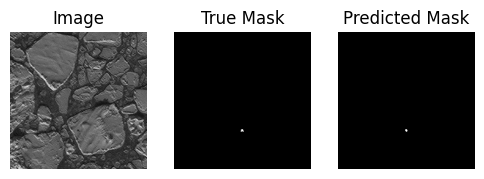

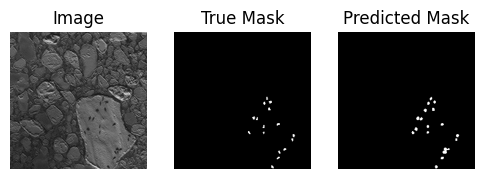

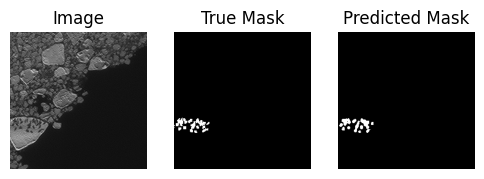

In [ ]:
# Visualization all test images!

'''
# Index of the image you want to visualize
for i in range(len(test_dataset)):
# Set visualization variables
  image, mask = test_dataset[i]
  image = image.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension
  mask = mask.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension

  best_model.eval()
  with torch.no_grad():
    pred = model(image)
  #print(f'Prediction shape: {pred.shape}')

  pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # Convert prediction to numpy array
  pred_print = (pred == 1).astype(float)

  fig, axes = plt.subplots(1, 3, figsize=(6, 2))
  image_np = image.squeeze().cpu().numpy()  # Keep the shape as (1, 224, 224) if it's a single channel
  if image_np.ndim == 3:
      image_np = image_np.transpose(1, 2, 0)  # Convert from tensor format (C, H, W) to (H, W, C)
  #print(f'Image shape for imshow: {image_np.shape}')
  axes[0].imshow(image_np.squeeze(), cmap='gray')  # Use grayscale if single channel
  axes[0].set_title('Image')
  axes[0].axis('off')

  mask_np = mask.squeeze().cpu().numpy()
  #print(f'True mask shape for imshow: {mask_np.shape}')
  axes[1].imshow(mask_np, cmap='gray')  # Convert mask to numpy array
  axes[1].set_title('True Mask')
  axes[1].axis('off')

  #print(f'Predicted mask shape for imshow: {pred_print.shape}')
  axes[2].imshow(pred_print, cmap='gray')  # Use grayscale colormap for binary mask
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

plt.show()
'''